
# 🧠 GoogleNet (Inception v1) on CIFAR-10


### Tsion Bizuayehu
## 📚 Background and Architecture

GoogleNet, also known as **Inception v1**, was introduced by **Szegedy et al.** in the landmark paper *"Going Deeper with Convolutions"* (2014). It was the winner of the ILSVRC 2014 classification challenge.

### 🧱 Built Upon Previous Architectures

Before GoogleNet, notable CNNs included:

- **LeNet (1998):** Introduced the basic idea of convolution + pooling layers.
- **AlexNet (2012):** Brought deep learning into the spotlight with ReLU, dropout, and GPU training.
- **ZFNet (2013):** Improved upon AlexNet using visualization and tweaking layer parameters.

### 🚀 What’s New in GoogleNet

- **Inception Modules**: Apply multiple convolutions (1x1, 3x3, 5x5) and pooling in parallel — their outputs are concatenated.
- **1x1 Convolutions**: Used for dimensionality reduction, making deep networks computationally feasible.
- **Auxiliary Classifiers**: Help prevent vanishing gradients and serve as regularizers.
- **No fully connected layers at the end**: Replaced with global average pooling to reduce parameters.

These improvements allowed GoogleNet to go **deeper (22 layers)** while keeping computation reasonable.






**Predecessor: LeNet, AlexNet, and ZFNet** laid the foundation for convolutional neural networks by introducing deep hierarchical architectures with convolutional and pooling layers.


This architecture allows the network to learn both fine and coarse features efficiently.

### Importing libraries


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D # Added GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


 ### Load and Preprocess Data (CIFAR-10)
This cell loads the CIFAR-10 dataset, normalizes pixel values to a [0, 1] range, and converts the labels to one-hot encoding, which is required for categorical cross-entropy loss.

In [5]:
print("Loading and preprocessing CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("Data loading and preprocessing complete.")

Loading and preprocessing CIFAR-10 dataset...
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)
Data loading and preprocessing complete.




### 📦 Inception Module


This cell defines the inception_module function. This function creates a single Inception block (Inception V1), which is the core building block of GoogleNet. It performs parallel convolutions and pooling operations, concatenating their outputs.

This block applies multiple filter sizes in parallel: 1x1, 3x3, and 5x5, along with a pooling branch. The outputs are concatenated along the channel dimension. It helps the model "see" at multiple spatial scales.

In [7]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    """
    Implements a single Inception module (Inception V1).
    Layer names updated to replace '/' with '_' for Keras 3 compatibility.
    """
    # Branch 1: 1x1 convolution
    branch_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', name=f'{name}_1x1')(x)

    # Branch 2: 1x1 convolution (reduce) then 3x3 convolution
    branch_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', name=f'{name}_3x3_reduce')(x)
    branch_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', name=f'{name}_3x3')(branch_3x3)

    # Branch 3: 1x1 convolution (reduce) then 5x5 convolution
    branch_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', name=f'{name}_5x5_reduce')(x)
    branch_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', name=f'{name}_5x5')(branch_5x5)

    # Branch 4: 3x3 Max Pooling then 1x1 convolution (projection)
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name=f'{name}_pool')(x)
    branch_pool = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', name=f'{name}_pool_proj')(branch_pool)

    # Concatenate all branches along the channel dimension
    output = concatenate([branch_1x1, branch_3x3, branch_5x5, branch_pool], axis=-1, name=name)
    return output


### 🏗️ GoogleNet Model Definition

Here we stack convolutional layers and inception modules together to form a compact version of GoogleNet suitable for CIFAR-10.

This cell defines the build_googlenet function, which assembles the entire GoogleNet architecture using the inception_module and other standard layers. It also includes the two auxiliary classifiers.

In [9]:
def build_googlenet(input_shape, num_classes):
    """
    Constructs the GoogleNet (Inception V1) architecture.
    Layer names updated for Keras 3 compatibility.
    Auxiliary and final pooling adapted for CIFAR-10's smaller image sizes.
    """
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Block
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1_7x7_s2')(input_tensor)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1_3x3_s2')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu', name='conv2_1x1')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu', name='conv2_3x3')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool2_3x3_s2')(x)

    # Inception Modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool3_3x3_s2')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')

    # Auxiliary Classifier 1 - **FIXED HERE**
    # Using GlobalAveragePooling2D and removed subsequent Conv2D and Flatten
    aux1 = GlobalAveragePooling2D(name='aux1_global_avg_pool')(x)
    aux1 = Dense(1024, activation='relu', name='aux1_fc1')(aux1)
    aux1 = Dropout(0.7, name='aux1_dropout')(aux1)
    aux1 = Dense(num_classes, activation='softmax', name='aux1_output')(aux1)


    x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')

    # Auxiliary Classifier 2 - **FIXED HERE**
    # Using GlobalAveragePooling2D and removed subsequent Conv2D and Flatten
    aux2 = GlobalAveragePooling2D(name='aux2_global_avg_pool')(x)
    aux2 = Dense(1024, activation='relu', name='aux2_fc1')(aux2)
    aux2 = Dropout(0.7, name='aux2_dropout')(aux2)
    aux2 = Dense(num_classes, activation='softmax', name='aux2_output')(aux2)


    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool4_3x3_s2')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

    # Final Classification Layers - Already fixed
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dropout(0.4, name='dropout_final')(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=[output, aux1, aux2], name='GoogleNet')
    return model

### Instantiate and Summarize the Model
This cell creates an instance of the GoogleNet model and prints its summary, which shows the layers, output shapes, and number of parameters. This is useful for verifying the architecture.

In [11]:
# Build the model
input_shape = x_train.shape[1:] # (32, 32, 3) for CIFAR-10
googlenet_model = build_googlenet(input_shape, num_classes)

# Display model summary
googlenet_model.summary()

Model: "GoogleNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_7x7_s2        │ (None, 16, 16,    │      9,472 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_3x3_s2        │ (None, 8, 8, 64)  │          0 │ conv1_7x7_s2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1x1 (Conv2D)  │ (None, 8, 8, 64)  │      4,160 │ pool1_3x3_s2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_3x3 (Conv2D)  │ (None, 8, 8, 192) │    110,784 │ conv2_1x1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_3x3_s2        │ (None, 4, 4, 192) │          0 │ conv2_3x3[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3_r… │ (None, 4, 4, 96)  │     18,528 │ pool2_3x3_s2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_5x5_r… │ (None, 4, 4, 16)  │      3,088 │ pool2_3x3_s2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_pool   │ (None, 4, 4, 192) │          0 │ pool2_3x3_s2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_1x1    │ (None, 4, 4, 64)  │     12,352 │ pool2_3x3_s2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3    │ (None, 4, 4, 128) │    110,720 │ inception_3a_3x3… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_5x5    │ (None, 4, 4, 32)  │     12,832 │ inception_3a_5x5… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_pool_… │ (None, 4, 4, 32)  │      6,176 │ inception_3a_poo… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 4, 4, 256) │          0 │ inception_3a_1x1… │
│ (Concatenate)       │                   │            │ inception_3a_3x3… │
│                     │                   │            │ inception_3a_5x5… │
│                     │                   │            │ inception_3a_poo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_3x3_r… │ (None, 4, 4, 128) │     32,896 │ inception_3a[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_5x5_r… │ (None, 4, 4, 32)  │      8,224 │ inception_3a[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_pool   │ (None, 4, 4, 256) │          0 │ inception_3a[0][

 Total params: 7,071,310 (26.97 MB)

 Trainable params: 7,071,310 (26.97 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model
This cell compiles the model. For GoogleNet, it's crucial to define multiple loss functions and their respective weights because of the auxiliary classifiers. The main output typically has a higher loss weight.

In [17]:
print("Compiling the GoogleNet model...")
googlenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss={'output': 'categorical_crossentropy',
                              'aux1_output': 'categorical_crossentropy', # Corrected output name
                              'aux2_output': 'categorical_crossentropy'}, # Corrected output name
                        loss_weights={'output': 1.0, 'aux1_output': 0.3, 'aux2_output': 0.3}, # Corrected output name
                        metrics={'output': 'accuracy',
                                 'aux1_output': 'accuracy', # Corrected output name
                                 'aux2_output': 'accuracy'}) # Corrected output name

print("Model compilation complete.")

Compiling the GoogleNet model...
Model compilation complete.


### Define Callbacks
This cell sets up Keras callbacks for better training management:

ModelCheckpoint: Saves the best model based on validation accuracy.
EarlyStopping: Stops training if validation accuracy doesn't improve for a certain number of epochs (patience).
ReduceLROnPlateau: Reduces the learning rate when a metric (validation accuracy) has stopped improving.

In [25]:
# Callbacks for better training management
checkpoint = ModelCheckpoint("googlenet_cifar10.keras", monitor='val_output_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_output_accuracy', patience=10, restore_best_weights=True, verbose=1, mode='max') # Added mode='max'
reduce_lr = ReduceLROnPlateau(monitor='val_output_accuracy', factor=0.5, patience=5, min_lr=0.00001, verbose=1, mode='max') # Added mode='max'

callbacks_list = [checkpoint, early_stopping, reduce_lr]

### Train the Model
This is the main training loop. It fits the model to the training data. Notice that y_train is passed as a dictionary for the multiple outputs. Training this model, especially on a CPU, will take a significant amount of time. It's highly recommended to use a GPU (e.g., in Google Colab).

In [39]:
print("Starting model training...")
# Ensure target dictionary keys match the output layer names defined in build_googlenet
history = googlenet_model.fit(x_train, {'output': y_train, 'aux1_output': y_train, 'aux2_output': y_train}, # Corrected output name
                              epochs=50, # You can adjust the number of epochs
                              batch_size=64,
                              validation_data=(x_test, {'output': y_test, 'aux1_output': y_test, 'aux2_output': y_test}), # Corrected output name
                              callbacks=callbacks_list,
                              verbose=1)
print("Model training complete.")

Starting model training...
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - aux1_output_accuracy: 0.7572 - aux1_output_loss: 0.6882 - aux2_output_accuracy: 0.7570 - aux2_output_loss: 0.7008 - loss: 1.1194 - output_accuracy: 0.7557 - output_loss: 0.7027
Epoch 1: val_output_accuracy improved from 0.65590 to 0.66850, saving model to googlenet_cifar10.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 151ms/step - aux1_output_accuracy: 0.7571 - aux1_output_loss: 0.6882 - aux2_output_accuracy: 0.7569 - aux2_output_loss: 0.7008 - loss: 1.1195 - output_accuracy: 0.7557 - output_loss: 0.7027 - val_aux1_output_accuracy: 0.6722 - val_aux1_output_loss: 0.9949 - val_aux2_output_accuracy: 0.6687 - val_aux2_output_loss: 1.0246 - val_loss: 1.6299 - val_output_accuracy: 0.6685 - val_output_loss: 1.0213 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - aux1_output_accuracy: 0.7757 - aux1_output_loss: 0.6462 - aux2_output_accuracy: 0.7765 - aux2_output_loss: 0.6580 - loss: 1.04

### Evaluate the Model
After training, this cell evaluates the model's performance on the unseen test dataset. It will print the total loss, and the loss and accuracy for the main output and each auxiliary output.

In [41]:
print("Evaluating the model on the test set...")
# Ensure target dictionary keys match the output layer names defined in build_googlenet
results = googlenet_model.evaluate(x_test, {'output': y_test, 'aux1_output': y_test, 'aux2_output': y_test}, verbose=1) # Corrected output name

print("\n--- Evaluation Results ---")
print(f"Total Loss: {results[0]:.4f}")
print(f"Main Output Loss: {results[1]:.4f}")
# The indices in 'results' will depend on the order of outputs in your model.
# It's usually: [total_loss, main_output_loss, aux1_loss, aux2_loss, main_output_accuracy, aux1_accuracy, aux2_accuracy]
print(f"Main Output Accuracy: {results[4]:.4f}")
print(f"Auxiliary 1 Output Loss: {results[2]:.4f}")
print(f"Auxiliary 1 Output Accuracy: {results[5]:.4f}")
print(f"Auxiliary 2 Output Loss: {results[3]:.4f}")
print(f"Auxiliary 2 Output Accuracy: {results[6]:.4f}")

Evaluating the model on the test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - aux1_output_accuracy: 0.6918 - aux1_output_loss: 1.3460 - aux2_output_accuracy: 0.6876 - aux2_output_loss: 1.3811 - loss: 2.1638 - output_accuracy: 0.6875 - output_loss: 1.3457

--- Evaluation Results ---
Total Loss: 2.1947
Main Output Loss: 1.3643
Main Output Accuracy: 0.6878
Auxiliary 1 Output Loss: 1.3617
Auxiliary 1 Output Accuracy: 0.6859
Auxiliary 2 Output Loss: 1.4010
Auxiliary 2 Output Accuracy: 0.6860



### 📈 Results Visualization


This cell uses Matplotlib to plot the training and validation accuracy and loss over epochs for the main output. This helps in understanding the training progress and identifying overfitting.

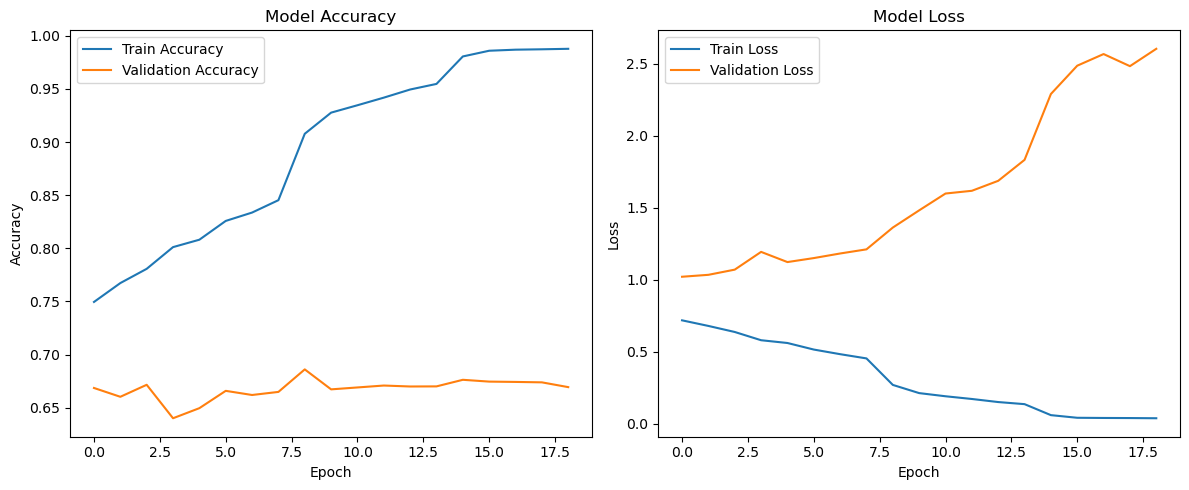

In [45]:
# Plotting training history for main output
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_output_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['output_loss'], label='Train Loss')
plt.plot(history.history['val_output_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### - Predict and Display Sample Images
This final cell provides a small function to pick a few random images from the test set, make predictions using the trained model, and display the image along with its true and predicted labels. This is a visual check of the model's performance.


--- Predictions on a few test images ---
Loaded best model from googlenet_cifar10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


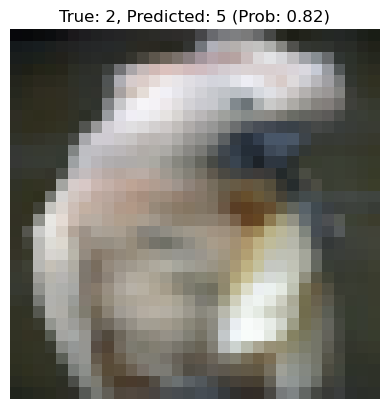

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


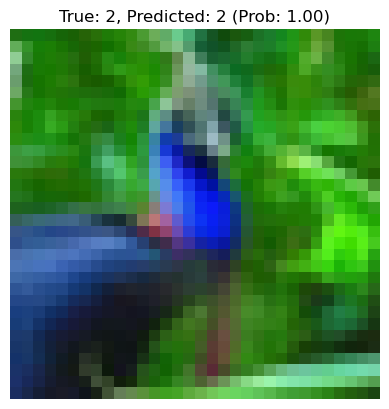

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


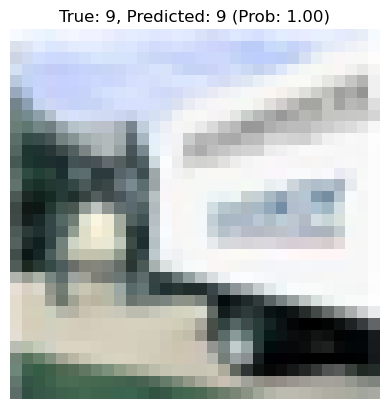

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


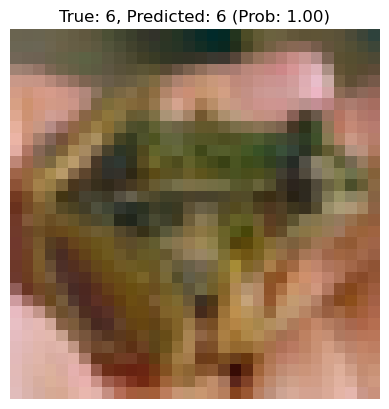

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


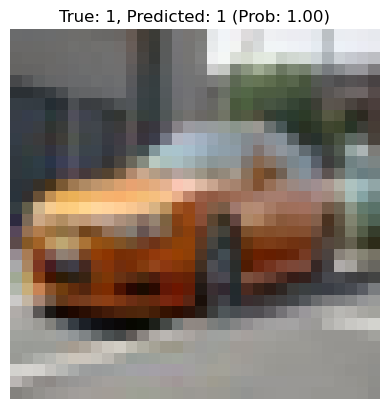

In [48]:
print("\n--- Predictions on a few test images ---")
num_samples_to_predict = 5
sample_indices = np.random.choice(len(x_test), num_samples_to_predict, replace=False)

# Load the best model saved by the checkpoint
try:
    best_model = tf.keras.models.load_model("googlenet_cifar10.keras")
    print("Loaded best model from googlenet_cifar10.keras")
except Exception as e:
    print(f"Could not load best model: {e}. Using the last trained model.")
    best_model = googlenet_model # Fallback to the model in memory if file not found

for i in sample_indices:
    img = x_test[i]
    true_label = np.argmax(y_test[i])
    # Predict with the main output
    # best_model.predict returns a list of outputs, we need the first one (main output)
    predicted_probs = best_model.predict(np.expand_dims(img, axis=0))[0]
    predicted_label = np.argmax(predicted_probs)

    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_label} (Prob: {np.max(predicted_probs):.2f})")
    plt.axis('off')
    plt.show()